## Data "validation" / sanity checking

In [48]:
!pwd

/c/Users/Mike/Dropbox/01 Purdue Thesis work/04 Experimental Study for Paper 2/data


In [49]:
filepath = 'master_trial_results.npy'

In [50]:
# create hash of file for posterity
import hashlib
import pathlib

hashlib.md5(pathlib.Path(filepath).read_bytes()).hexdigest()

'252424522381659ffd8887463ffd4f25'

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

data = np.load(filepath)
print(data.shape)

# assign the empty trial to nan to avoid confusion later
data[0] = np.nan

(1801, 501, 6, 2)


the 0th entry on the first dimension is blank so that all trials are indexed by their trial number 1..1800

the 0th entry on the second dimension is the entropy value from agent initial conditions

the final dimension is [mean, standard deviation]

In [6]:
# a quick way to check that a time series does vary is the peak-to-peak value should be > 0
(np.ptp(data[1:, :, :, 0], axis=1) > 0).all()

True

In [52]:
response_variable_labels = {
    0: 'relative entropy, binning (RE-B)',
    1: 'mutual information, binning (MI-B)',
    2: 'transfer entropy, binning (TE-B)',
    3: 'relative entropy, symbolic approach (RE-S)',
    4: 'mutual information, symbolic approach (MI-S)',
    5: 'transfer entropy, symbolic approach (TE-S)',
    }
response_variable_short_labels = {
    0: 'RE-B',
    1: 'MI-B',
    2: 'TE-B',
    3: 'RE-S',
    4: 'MI-S',
    5: 'TE-S',
    }
# array indexes
BINNING_RELATIVE  = 0
BINNING_MUTUAL    = 1
BINNING_TRANSFER  = 2
SYMBOLIC_RELATIVE = 3
SYMBOLIC_MUTUAL   = 4
SYMBOLIC_TRANSFER = 5

MIN_TRIAL, MAX_TRIAL = 1, 1800
MIN_T, MAX_T = 0, 500

INDEX_MEANS, INDEX_STDEV = 0, 1

## Data summary plots

I think it may be easiest to use one notebook for each RV

In [53]:
# plot styling
plt.style.use('seaborn-colorblind')


from my_plot import set_size, setup_mpl_for_latex
setup_mpl_for_latex()

textwidth = 390  ###

In [54]:



rv = 0  # just to select single response variable

print(data[MIN_TRIAL:, :, rv, INDEX_MEANS].min(), data[MIN_TRIAL:, :, rv, INDEX_MEANS].max())

0.08637433792615036 5.67242534197233


In [12]:
# for transfer entropy, need to truncate the last t;
# for symbolic entropy, need to truncate the last few t's
MAX_T = 50  ###

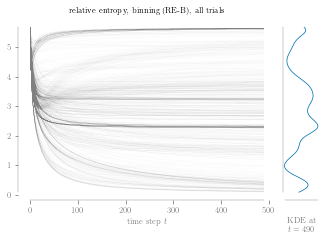

In [28]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=set_size(textwidth), gridspec_kw={'width_ratios': [7, 1], 'wspace': 0.05}, sharey=True)


for i in range(MIN_TRIAL, MAX_TRIAL+1):
    ax1.plot(data[i, MIN_T:MAX_T+1, rv, INDEX_MEANS], marker='', color='grey', linewidth=0.05, alpha=0.15)
#     break ###

ax1.set_title(f'{response_variable_labels[rv]}, all trials')
ax1.set_xlabel('time step $t$', color='grey')

# more decoration
ax1.spines['bottom'].set_color('grey')
ax1.spines['left'].set_color('grey')

ax1.tick_params(axis='x', colors='grey')
ax1.tick_params(axis='y', colors='grey')

ax1.spines['bottom'].set_bounds(MIN_T, MAX_T)
ax1.spines['left'].set_bounds(data[MIN_TRIAL:, MIN_T:MAX_T+1, rv, INDEX_MEANS].min(), 
                              data[MIN_TRIAL:, MIN_T:MAX_T+1, rv, INDEX_MEANS].max())


# in subplot 2, add KDE for final timestep data

# manually computing KDE so I can add it to a subplot
# from https://stackoverflow.com/a/4152016/5437547
from scipy.stats import gaussian_kde

density = gaussian_kde(data[MIN_TRIAL:, MAX_T, rv, INDEX_MEANS].reshape(1, -1))
xs = np.linspace(data[MIN_TRIAL:, MIN_T:MAX_T+1, rv, INDEX_MEANS].min(), 
                 data[MIN_TRIAL:, MIN_T:MAX_T+1, rv, INDEX_MEANS].max(), 200)
density.covariance_factor = lambda : .15
density._compute_covariance()
density_xs = density(xs)

ax2.plot(density_xs, xs, marker='', linewidth=0.75)

ax2.set_xlabel(f'KDE at\n$t={MAX_T}$', color='grey')

# more decoration
ax2.spines['bottom'].set_color('grey')
ax2.spines['left'].set_color('grey')
# ax2.spines['left'].set_visible(False)
ax2.get_yaxis().set_visible(False)

ax2.tick_params(axis='x', colors='None')

ax2.spines['left'].set_bounds(data[MIN_TRIAL:, MIN_T:MAX_T+1, rv, INDEX_MEANS].min(), 
                              data[MIN_TRIAL:, MIN_T:MAX_T+1, rv, INDEX_MEANS].max())
ax2.spines['bottom'].set_bounds(density_xs.min(), density_xs.max())

# want to make y-axis consistent across multiple plots, sometimes
ybound = ax1.get_ybound()


In [9]:
fig1.savefig(f'all_trials_line_plot_with_kde_rv_{rv}.pdf', format='pdf', bbox_inches='tight')

In [10]:
# sns.distplot(data[MIN_TRIAL:, -1:, rv, INDEX_MEANS].reshape(-1, 1));  # distribution of data at final time

# RQ 1 - DoE/ANOVA

In [55]:
design_df = pd.read_csv('../code/design.csv', index_col=0, dtype=str)


In [56]:
df = pd.DataFrame(data[MIN_TRIAL:, MIN_T:MAX_T+1, rv, INDEX_MEANS])  # |TRIALS| x t_max
df.index = design_df.index

ddff = design_df.join(df)
ddff.head()

,agent_activation_regime,influence_error_distribution,influence_model,network_structure_model,population_size,0,1,2,3,4,...,491,492,493,494,495,496,497,498,499,500
1,synchronous,none,standard_model,erdos_renyi_random(N),100,5.672425,4.774825,4.379856,4.265721,4.298114,...,5.623543,5.623628,5.623713,5.623797,5.623881,5.623965,5.624048,5.624131,5.624214,5.624296
2,synchronous,none,standard_model,erdos_renyi_random(N),1000,5.672425,4.766025,4.386170,4.307717,4.367688,...,5.628491,5.628567,5.628643,5.628719,5.628795,5.628870,5.628945,5.629020,5.629094,5.629169
3,synchronous,none,standard_model,erdos_renyi_random(N),10000,5.672425,4.765997,4.405909,4.361990,4.436167,...,5.631883,5.631953,5.632024,5.632094,5.632164,5.632233,5.632303,5.632372,5.632440,5.632509
4,synchronous,none,standard_model,"small_world(N, 0.0, 3)",100,5.672425,4.862425,4.543055,4.435644,4.424806,...,5.616502,5.616599,5.616695,5.616791,5.616887,5.616982,5.617077,5.617171,5.617265,5.617359
5,synchronous,none,standard_model,"small_world(N, 0.0, 3)",1000,5.672425,4.860955,4.543280,4.429603,4.412860,...,5.614077,5.614178,5.614278,5.614378,5.614478,5.614577,5.614676,5.614774,5.614872,5.614970


In [57]:
# copied from code/experimental_design.py, edited to make population_size levels into strings


factors = dict(
    population_size=[
        '100',
        '1000',
        '10000',
    ],
    network_structure_model=[
        'erdos_renyi_random(N)',
        'small_world(N, 0.0, 3)',
        'small_world(N, 0.0, 10)',
        'small_world(N, 0.33, 3)',
        'small_world(N, 0.33, 10)',
        'small_world(N, 0.66, 3)',
        'small_world(N, 0.66, 10)',
        'scale_free(N, 1)',
        'scale_free(N, 3)',
        'scale_free(N, 5)',
    ],
    influence_model=[
        'standard_model',
        'similarity_bias',
        'attractive_repulsive',
        'random_adoption',
        'nonlinear',
    ],
    influence_error_distribution=[
        'none',
        'N(0, 0.05)',
        'N(0, 0.1)',
        'N(0, 0.2)',
    ],
    agent_activation_regime=[
        'synchronous',
        'uniform',
        'random',
    ],
)

In [58]:
# ANOVA on the final ($t = 500$) data for single r.v.
# (this dataframe is handy for things other than ANOVA, so it's created up here)
anova_df = design_df.copy()
anova_df['response'] = data[MIN_TRIAL:, MAX_T, rv, INDEX_MEANS]

In [59]:
def split_dataframe_on_factor_into_levels(df, factor, col=None):
    """Helper function to return X separate data frames or columns by splitting a factor into its levels."""
    levels = df[factor].unique()
    
    if col:
        frames = (df[col][df[factor] == level] for level in levels)
    else:
        frames = (df[df[factor] == level] for level in levels)
    return frames

In [60]:
# DoE mean plot - data collection

label_map = dict(  # decorative strings for graphs
    agent_activation_regime='activation',
    influence_error_distribution='error',
    influence_model='influence model',
    network_structure_model='structure',
    population_size='$N$',
)


# means = []  # mean value for each factor-level
# stdevs = []
# for factor, levels in factors.items():
#     group_means = ddff.groupby(factor).mean()[MAX_T]
#     group_stdevs = ddff.groupby(factor).std()[MAX_T]
#     for level in levels:
#         means.append(group_means[level])
#         stdevs.append(group_stdevs[level])


In [61]:
# prepare plot data
import string
string.ascii_lowercase

cur_x = factor_start = factor_end = 0
xticks = []
xlabels = []
factor_name_xs = []
legend = []

for i, (factor, factor_levels) in enumerate(factors.items()):
    cur_x += 1  # add horizontal space before factor
    factor_start = cur_x
    
    for l, lvl in enumerate(factor_levels):
        xticks.append(cur_x)
        xlabels.append(string.ascii_lowercase[l])
        cur_x += 1

        legend.append( (factor, lvl, string.ascii_lowercase[l]))
                
        # add some gaps between dissimilar models
        if factor == 'network_structure_model':
            if l in [0, 6]:
                cur_x += 0.6
                
        
    factor_end = cur_x
    factor_name_xs.append((label_map[factor], 0.5*(factor_end-1 + factor_start)))
    
    cur_x += 1  # add horizontal space after factor
    
# xticks, xlabels, 
# factor_name_xs, legend

In [62]:
legend

[('population_size', '100', 'a'),
 ('population_size', '1000', 'b'),
 ('population_size', '10000', 'c'),
 ('network_structure_model', 'erdos_renyi_random(N)', 'a'),
 ('network_structure_model', 'small_world(N, 0.0, 3)', 'b'),
 ('network_structure_model', 'small_world(N, 0.0, 10)', 'c'),
 ('network_structure_model', 'small_world(N, 0.33, 3)', 'd'),
 ('network_structure_model', 'small_world(N, 0.33, 10)', 'e'),
 ('network_structure_model', 'small_world(N, 0.66, 3)', 'f'),
 ('network_structure_model', 'small_world(N, 0.66, 10)', 'g'),
 ('network_structure_model', 'scale_free(N, 1)', 'h'),
 ('network_structure_model', 'scale_free(N, 3)', 'i'),
 ('network_structure_model', 'scale_free(N, 5)', 'j'),
 ('influence_model', 'standard_model', 'a'),
 ('influence_model', 'similarity_bias', 'b'),
 ('influence_model', 'attractive_repulsive', 'c'),
 ('influence_model', 'random_adoption', 'd'),
 ('influence_model', 'nonlinear', 'e'),
 ('influence_error_distribution', 'none', 'a'),
 ('influence_error_di

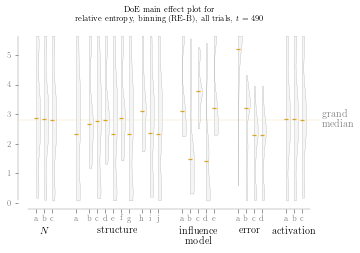

In [37]:
# DoE violin plot

fig1, ax1 = plt.subplots(1, 1, figsize=set_size(textwidth))

# assemble x tick labels
ax1.set_xticks(xticks)
ax1.set_xticklabels(xlabels)

grand_median = df.median().iloc[-1]
# grand_stdev = df.std().iloc[-1]
ax1.axhline(y=grand_median, color='goldenrod', linewidth=0.15, linestyle='-', zorder=0)
ax1.annotate('grand\nmedian', (xticks[-1]+2.5, grand_median), ha='left', va='center', annotation_clip=False, color='grey')

last_offset = 0
for i, (factor, levels) in enumerate(factors.items()):
    num_levels = len(levels)
    x = xticks[last_offset:last_offset+num_levels]
#     y = means[last_offset:last_offset+num_levels]
 
    groups = list(split_dataframe_on_factor_into_levels(anova_df, factor, col='response'))

#  Axes.violinplot(self, dataset, positions=None, vert=True, widths=0.5, 
# showmeans=False, showextrema=True, showmedians=False, points=100, bw_method=None, *, data=None)
    v1 = ax1.violinplot(groups, positions=x, widths=1.0, showmeans=False, showmedians=True, showextrema=False)

    last_offset += num_levels
    
    # make single-sided & adjust color
    for b in v1['bodies']:
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
        b.set_facecolor('whitesmoke')
        b.set_edgecolor('grey')
        b.set_linewidth(0.20)
        b.set_alpha(1)

    v1['cmedians'].set_color('goldenrod')
    v1['cmedians'].set_linewidth(1.25)

        
# label factor names
y = ax1.get_ybound()[0]
for label, x in factor_name_xs:
    ax1.annotate(label.replace(' ', '\n'), (x, y), 
                 fontsize=10,
                 textcoords="offset points", # how to position the text
                 xytext=(0,-18), # distance from text to points (x,y)
                 ha='center', va='top', annotation_clip=False)
    
ax1.set_title(f'DoE main effect plot for\n{response_variable_labels[rv]}, all trials, $t = {MAX_T}$')

# more decoration
ax1.spines['bottom'].set_color('grey')
ax1.spines['left'].set_color('grey')

ax1.tick_params(axis='x', colors='grey')
ax1.tick_params(axis='y', colors='grey')

ax1.spines['bottom'].set_bounds(xticks[0]-1, xticks[-1]+1)
ax1.spines['left'].set_bounds(anova_df['response'].min(), anova_df['response'].max())

# ax1.set_ylim(ybound);


In [19]:
fig1.savefig(f'doe_violin_plot_rv_{rv}.pdf', format='pdf', bbox_inches='tight')

In [63]:
# remove label overlap

# other resources
# https://stackoverflow.com/questions/8850142/matplotlib-overlapping-annotations
# https://matplotlib.org/users/transforms_tutorial.html

def fix_vertical_text_placement(labels, fig, ax, maxy):
    # modified from
    # https://medium.com/@adarshlilha/removing-label-overlapping-from-pretty-charts-8dd2e3581b71
    
    # pixel coordinates
    extents = [lab.get_window_extent(renderer=fig.canvas.get_renderer()) for lab in labels]
    anchors = [0.5*(extent.y0 + extent.y1) for extent in extents]  # vert.align centers

    cur_y_vals = anchors.copy()

    half_height = labels[0].get_size() / 2

    # S.A. params
    weight_overlap = 100
    weight_dist = 8
    max_move = half_height
    
    min_y = 0
    max_y = ax.transData.transform((0, maxy))[1]  #maxy given in data coords
    
    def energy(index):
        ener = 0

        # L1 norm
        dist = abs(cur_y_vals[index] - anchors[index])
        if dist > 0:
            ener += dist * dist * weight_dist  # making non-linear function to favor a balanced distance for label pairs

        y_index_top = cur_y_vals[index] + half_height
        y_index_bot = cur_y_vals[index] - half_height
        
        for i, extent in enumerate(extents):
            if i == index:  continue

            y_i_top = cur_y_vals[i] + half_height
            y_i_bot = cur_y_vals[i] - half_height

            y_overlap = max(0, min(y_index_top, y_i_top) - max(y_index_bot, y_i_bot))
            ener += y_overlap * weight_overlap

        return ener
    
    nsweeps = 2000
    
    # run loop
    currTemp = 1.0
    initialTemp = 1.0
    rej = 0
    
    for _ in range(nsweeps):
        for lab in labels:
            i = np.random.randint(0, len(labels))  # randomly select label index

            y_old = cur_y_vals[i]
            old_energy = energy(i)

            cur_y_vals[i] += (np.random.random() - 0.5) * max_move

            if cur_y_vals[i] < min_y or cur_y_vals[i] > max_y:
                # new move out of bounds
                cur_y_vals[i] = y_old
                delta_energy = 0
            else:
                new_energy = energy(i)
                delta_energy = new_energy - old_energy
                
            # randomly accept or reject new move
            if np.random.random() < np.exp(-delta_energy / currTemp):
                pass
            else:
                # reject move
                cur_y_vals[i] = y_old
                rej += 1
            
        currTemp = currTemp - (initialTemp / nsweeps)

    # apply new positions
    inv = ax.transData.inverted()
    for label, new_y in zip(labels, cur_y_vals):
        label.set_y(inv.transform((0, new_y))[1])

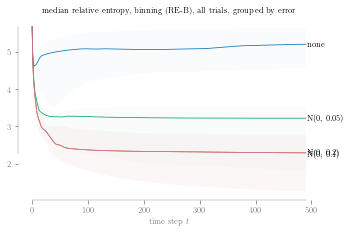

In [39]:
# time-series line plot, single RV, single design factor, grouped by level + level median line + 25-75 percentile shading

def make_median_entropy_plot(rv_num):
    factor = list(factors.keys())[rv_num]  # just doing single factor for now

    fig1, ax1 = plt.subplots(1, 1, figsize=set_size(textwidth))

    levels = factors[factor]

    minval, maxval = 100, -100  # for setting vertical range frame
    linelabels = []

    lower_quantile, upper_quantile = .25, .75

    for level in levels:
        level_data = df.loc[design_df[factor] == level]
        level_median = level_data.median()
        level_lower_quantile = level_data.quantile(lower_quantile)
        level_upper_quantile = level_data.quantile(upper_quantile)

        ax1.plot(level_median, marker='',  linewidth=0.75)
        linelabels.append(ax1.annotate(level.replace('_', '\_'), (level_median.index[-1]+1.5, level_median.iloc[-1]), 
                                       fontsize=8, ha='left', va='center', annotation_clip=False, color='black'))

        ax1.fill_between(level_median.index, level_lower_quantile, level_upper_quantile, alpha=0.025)

        # update extrema for vertical range frame
        minval = min(minval, level_median.min())
        maxval = max(maxval, level_median.max())

    ax1.set_title(f'median {response_variable_labels[rv]}, all trials, grouped by {label_map[factor]}')
    ax1.set_xlabel('time step $t$', color='grey')

    # more decoration
    ax1.spines['bottom'].set_color('grey')
    ax1.spines['left'].set_color('grey')

    ax1.tick_params(axis='x', colors='grey')
    ax1.tick_params(axis='y', colors='grey')

    ax1.spines['bottom'].set_bounds(MIN_T, MAX_T)
    ax1.spines['left'].set_bounds(minval, maxval)

#     ax1.set_ylim(ybound);  # cloning y-axis bounds from earlier chart for consistency ###
    
    fix_vertical_text_placement(linelabels, fig1, ax1, maxval)

    fig1.savefig(f'xxgrouped_time_series_{factor}_rv_{rv}.pdf', format='pdf', bbox_inches='tight')

    
# for i in range(5):
#     make_median_entropy_plot(i)

make_median_entropy_plot(3)

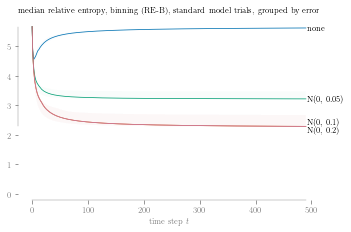

In [41]:
# time-series line plot, single RV, single design factor, grouped by level + level median line + 25-75 percentile shading

def make_median_entropy_plot2(rv_num):  ## this is actually design factor, not rv
    factor = list(factors.keys())[rv_num]  # just doing single factor for now

    fig1, ax1 = plt.subplots(1, 1, figsize=set_size(textwidth))

    levels = factors[factor]

    minval, maxval = 100, -100  # for setting vertical range frame
    linelabels = []

    lower_quantile, upper_quantile = .25, .75

    for level in levels:
        level_data = df.loc[(design_df[factor] == level) & (design_df['influence_model'] == 'standard_model')]
        level_median = level_data.median()
        level_lower_quantile = level_data.quantile(lower_quantile)
        level_upper_quantile = level_data.quantile(upper_quantile)

        ax1.plot(level_median, marker='',  linewidth=0.75)
        linelabels.append(ax1.annotate(level.replace('_', '\_'), (level_median.index[-1]+1.5, level_median.iloc[-1]), 
                                       fontsize=8, ha='left', va='center', annotation_clip=False, color='black'))

        ax1.fill_between(level_median.index, level_lower_quantile, level_upper_quantile, alpha=0.025)

        # update extrema for vertical range frame
        minval = min(minval, level_median.min())
        maxval = max(maxval, level_median.max())

    ax1.set_title(f'median {response_variable_labels[rv]}, standard model trials, grouped by {label_map[factor]}')
    ax1.set_xlabel('time step $t$', color='grey')

    # more decoration
    ax1.spines['bottom'].set_color('grey')
    ax1.spines['left'].set_color('grey')

    ax1.tick_params(axis='x', colors='grey')
    ax1.tick_params(axis='y', colors='grey')

    ax1.spines['bottom'].set_bounds(MIN_T, MAX_T)
    ax1.spines['left'].set_bounds(minval, maxval)

    ax1.set_ylim(ybound);  # cloning y-axis bounds from earlier chart for consistency ###
    
    fix_vertical_text_placement(linelabels, fig1, ax1, maxval)

    fig1.savefig(f'xxgrouped_time_series_{factor}_rv_{rv}.pdf', format='pdf', bbox_inches='tight')

    
# for i in range(5):
#     make_median_entropy_plot(i)

make_median_entropy_plot2(3)

### ANOVA/statistical comparison

In [64]:
for factor in factors:
    print(factor, ":", stats.levene(*split_dataframe_on_factor_into_levels(anova_df, factor, col='response')))

population_size : LeveneResult(statistic=0.21245008427621742, pvalue=0.8086209837845645)
network_structure_model : LeveneResult(statistic=11.292772417993366, pvalue=2.4526215755276226e-17)
influence_model : LeveneResult(statistic=29.46793436742128, pvalue=9.127179596550643e-24)
influence_error_distribution : LeveneResult(statistic=10.113397742118345, pvalue=1.3179067262052837e-06)
agent_activation_regime : LeveneResult(statistic=0.0767290368055423, pvalue=0.9261438037335981)


<These remarks held for RV 0/1> Of the Levene's test results for the five design factors on the current response variable, only activation regime and population size were not significant, indicating the levels for those factors can be assumed to have equal variance. The remaining three factors violate the assumption of homogeneity of variance.

Because the data is not normally distributed and 3/5 of design factors violate the assumption of homogeneity of variance, standard ANOVA is inappropriate. Instead, we use the non-parametric approach of the Kruskal-Wallace test to statistically determine if varying the level of each factor has a significant effect on the response variable.




In [65]:
# make table for K-W test results
kw_data = np.zeros((len(factors), 2))

for i, factor in enumerate(factors.keys()):
#     print(factor, ":", stats.kruskal(*split_dataframe_on_factor_into_levels(anova_df, factor, col='response')))
    kw_cur_result = stats.kruskal(*split_dataframe_on_factor_into_levels(anova_df, factor, col='response'))
    kw_data[i, 0] = kw_cur_result.statistic
    kw_data[i, 1] = kw_cur_result.pvalue
    
kw_results = pd.DataFrame(kw_data, [label_map[factor] for factor in factors], ['test stat', 'p-value'])
print(kw_results.to_latex())
print(kw_results)

\begin{tabular}{lrr}
\toprule
{} &   test stat &        p-value \\
\midrule
\$N\$             &    2.054700 &   3.579543e-01 \\
structure       &   29.375194 &   5.600331e-04 \\
influence model &  622.074718 &  2.584627e-133 \\
error           &  892.127230 &  4.515157e-193 \\
activation      &    0.138189 &   9.332386e-01 \\
\bottomrule
\end{tabular}

                  test stat        p-value
$N$                2.054700   3.579543e-01
structure         29.375194   5.600331e-04
influence model  622.074718  2.584627e-133
error            892.127230  4.515157e-193
activation         0.138189   9.332386e-01


Based on the p-values from the Kruskal-Wallace test, when the data is split into levels for both population size and activation regime, the data appear to come from the same population. Practically, this suggests that varying these factors (over the levels specified in our experiment) does not have a significant effect on the response variable. This agrees with what we observe in the DoE means plot and time series mean graphs.

Then, we use the Mann-Whitney U test for post-hoc comparison testing to determine which levels are different.

C:\Users\Mike\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less_equal


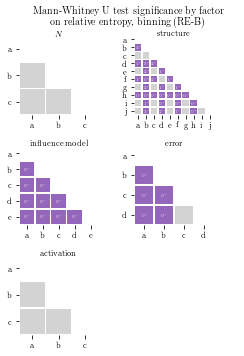

In [66]:
from itertools import combinations

from matplotlib import colors


def make_mann_whitney_heatmap(factor, ax, significance_level=0.05):
    # if the p-value is significant (< 0.05), we conclude the two groups are different
    grouped_data = list(split_dataframe_on_factor_into_levels(anova_df, factor, col='response'))
    levels = anova_df[factor].unique()
    
    pvals = np.full((levels.size, levels.size), np.nan)
    for i, li in enumerate(levels):
        for j, lj in enumerate(levels):
            if i > j:
                res = stats.mannwhitneyu(grouped_data[i], grouped_data[j])
                pvals[i, j] = res[1]
                
    significant = (pvals <= significance_level)
    significant[pvals == np.nan] = np.nan    
    
    cmap = colors.ListedColormap(['lightgrey', 'tab:purple'])
    cmap.set_bad('white',1.)
    bounds=[0,significance_level,1]
    norm = colors.BoundaryNorm(bounds, cmap.N)
        
    masked_array = np.ma.array (significant, mask=np.isnan(pvals))
    
    # pcolormesh requires more +0.5'ing than imshow but avoids bug with minor grid alignment
    ax.pcolormesh(masked_array, edgecolors='w', linewidth=0.5, cmap=cmap, vmin=0, vmax=1)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    
    ax.set_title(label_map[factor].replace('_', ' '), size=8, y=0.91)

    # We want to show all ticks...
    ax.set_xticks(np.arange(levels.size)+0.5)
    ax.set_yticks(np.arange(levels.size)+0.5)
    
    # ... and label them with the respective list entries
    ax.set_xticklabels(string.ascii_lowercase[:levels.size])
    ax.set_yticklabels(string.ascii_lowercase[:levels.size])

    # hide spines
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    # Loop over data dimensions and create text annotations.
    for i, li in enumerate(levels):
        for j, lj in enumerate(levels):
            if significant[i, j]:
                text = ax.text(j+0.5, i+0.5, f"${int(pvals[i, j]*100)}^*$",
                               ha="center", va="center", color="w", fontsize=4)

    
fig, axes = plt.subplots(3, 2, figsize=set_size(textwidth, subplot=[3, 2]))

for factor, ax in zip(factors, axes.reshape(-1)):
    make_mann_whitney_heatmap(factor, ax)
#     break

axes[-1, -1].axis('off')

fig.suptitle(f'Mann-Whitney U test significance by factor\non {response_variable_labels[rv]}', size=10, x=0.370);
fig.tight_layout()
fig.subplots_adjust(top=0.90, right=0.65)


In [29]:
fig.savefig(f'mann_whitney_rv_{rv}.pdf', format='pdf', bbox_inches='tight')

Some interesting observations can be made about what pairwise results are/are not significant. For example, in the network structure models, the ER random graph is significantly different from the networks with small degree parameters but not with larger degree parameters. The M-W U test finds a significant difference between the standard model and nonlinear influence models, which is not apparent from the DoE means plot and time series plot (noting that tests on ranked data are typically different than on the data itself).


# RQ 2 - Cluster analysis


workflow for cluster analysis

For each distance/dissimilarity metric in {DTW, Pearson corr.}:

#### In R:
1. compute distance/dissimilarity metric between each pair of trial results
2. run NbClust battery to find most popular number of clusters
3. use HAC (not part of battery) and cut tree at most popular number of clusters
4. export list of cluster ids for each trial to CSV

#### In Python:
5. import list of cluster numbers from CSV and join with design_df
6. plot data timeseries to show clusters
7. generate percentages "heatmaps"
8. draw conclusions about nature of clusters

in R, npyLoad can only handle 2d .npy files, so we split the data file by RV and keep only the means (the actual response values)

In [67]:
# # preprocessing/file manip -- only need to do once for whole experiment

# for i in range(6):
#     np.save(f'split_master_trial_results_rv_{i}.npy', data[MIN_TRIAL:, :, i, INDEX_MEANS] )

In [68]:
modes = ['dtw', 'pearson']

mode_fmt = dict(dtw="DTW", pearson="Pearson")

... moving to R for cluster analysis ... then back here for presentation of results

In [73]:
rv = 0

# load "best" cluster indices produced by R

clusters_df = design_df.copy()

for mode in modes:
    # load R's cluster indices from file
    with open(f'./{mode}_best_clusters_rv_{rv}.csv', 'r') as f:
        cluster_ids = [int(i) for i in f.readline()[:-1].split(',')]
        
    clusters_df[f'cluster_{mode}'] = cluster_ids
    
    

In [74]:
mode = 'dtw'

print(clusters_df[f'cluster_{mode}'].unique())

[1 2 3 4]


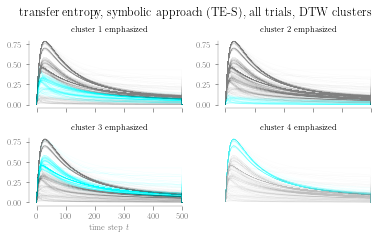

In [72]:
def make_cluster_highlighted_line_plot(mode, cluster_num, clusters_df, ax1):
    if cluster_num < 1:
        print("cluster numbers start at 1")
        return
    
    for i in range(MIN_TRIAL, MAX_TRIAL+1):
        if clusters_df.loc[i][f'cluster_{mode}'] == cluster_num:
            ax1.plot(data[i, MIN_T:MAX_T+1, rv, INDEX_MEANS], marker='', color='cyan', linewidth=0.05, alpha=0.20)#, zorder=10)
        else:
            ax1.plot(data[i, MIN_T:MAX_T+1, rv, INDEX_MEANS], marker='', color='grey', linewidth=0.05, alpha=0.15)
#         break##
        
    ax1.set_title(f'cluster {cluster_num} emphasized', size=8)
    
#     ax1.set_xlabel('time step $t$', color='grey')
    

    # more decoration+
    ax1.spines['bottom'].set_color('grey')
    ax1.spines['left'].set_color('grey')

    ax1.tick_params(axis='x', colors='grey')
    ax1.tick_params(axis='y', colors='grey')

    ax1.spines['bottom'].set_bounds(MIN_T, MAX_T)
    ax1.spines['left'].set_bounds(data[1:, MIN_T:MAX_T+1, rv, INDEX_MEANS].min(), data[1:, MIN_T:MAX_T+1, rv, INDEX_MEANS].max())


nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows, ncols, figsize=set_size(textwidth, subplot=[nrows, ncols]), sharex=True)

for cluster_num, ax in zip(sorted(clusters_df[f'cluster_{mode}'].unique()), axes.reshape(-1)):
    make_cluster_highlighted_line_plot(mode, cluster_num, clusters_df, ax)
#     break##

axes[-1, 0].set_xlabel('time step $t$', color='grey')
axes[-1, 1].set_xlabel('time step $t$', color='grey')


# axes[-1, 2].set_xlabel('time step $t$', color='grey')

axes[-1, -1].axis('off')
                           
fig.suptitle(f'{response_variable_labels[rv]}, all trials, {mode_fmt[mode]} clusters')
fig.tight_layout()
fig.subplots_adjust(top=0.75 if nrows == 1 else 0.85)  # use .85 except for a single row, then .75

In [38]:
fig.savefig(f'all_trials_cluster_emphasis_{mode}_rv_{rv}.pdf', format='pdf', bbox_inches='tight')    

In [44]:
# Cluster percentage plot, clustering method, single RV, single cluster

mode = 'dtw'


In [75]:
def get_census_vals(mode):
    cluster_nums = sorted(clusters_df[f'cluster_{mode}'].unique())
    census_vals = []  # count of trials with both a given factor-level and cluster number divided by cluster size
    rows = []  # row labels


    for (factor, levels) in factors.items():

        for i, level in enumerate(levels):
    #         rows.append(f"{level}")
            rows.append(f"{string.ascii_lowercase[i]}")

            # "census" of each cluster..."what does each cluster look like?"...take frequency per factor per cluster
            census_vals.append([len(clusters_df[(clusters_df[f'cluster_{mode}'] == cluster_num) & (clusters_df[factor] == level)]) 
                             / len(clusters_df[(clusters_df[f'cluster_{mode}'] == cluster_num)]) for cluster_num in cluster_nums])

        rows.append('')  # blank label for between factors
        census_vals.append([np.nan]*len(cluster_nums))  # blank data to render as gap

    census_vals = np.array(census_vals[:-1]).T  # remove last element since it's blank
    return census_vals, np.array(rows[:-1]), cluster_nums
                    

census_vals, row_labels, cluster_nums = get_census_vals(mode)                    

In [76]:
gap_indices = np.argwhere(row_labels == '').reshape(-1)
gap_indices = np.insert(gap_indices, [0, gap_indices.size], [-1, row_labels.size])
factor_name_xs = 0.5 + (gap_indices[1:] + gap_indices[:-1]) / 2

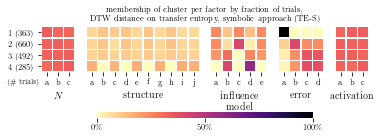

In [138]:
# based on https://matplotlib.org/3.1.0/gallery/images_contours_and_fields/image_annotated_heatmap.html?highlight=heatmap

fig, ax = plt.subplots(1, 1, figsize=set_size(textwidth))

pcm = ax.pcolormesh(census_vals, edgecolors='w', linewidth=0.5, vmin=0, vmax=1, cmap='magma_r')
ax.set_aspect('equal')
ax.invert_yaxis()

cbar = ax.figure.colorbar(pcm, ax=ax, shrink=0.66, aspect=40, pad=0.185,
                          orientation='horizontal', ticks=[0, 0.5, 1], drawedges=False)
cbar.ax.set_xticklabels(['0\%', '50\%', '100\%'])
cbar.outline.set_color('None')

ax.set_title(f"membership of cluster per factor by fraction of trials,\n{mode_fmt[mode]} distance on {response_variable_labels[rv]}")

# We want to show all ticks...
ax.set_yticks(np.arange(len(cluster_nums))+0.5)
ax.set_xticks(np.arange(len(row_labels))+0.5)
# ... and label them with the respective list entries
ax.set_yticklabels(cluster_nums)
ax.set_xticklabels(row_labels)

# add trial counts for cluster size
ax.annotate('(\# trials)', (-3, 5), fontsize=7, annotation_clip=False)
ax.set_yticklabels([f'{i} ({j})' for i, j in clusters_df.groupby(by=f'cluster_{mode}').agg('size').iteritems()])

# hide the tick marks for the gaps
xticks = ax.xaxis.get_major_ticks()
for i in gap_indices[1:-1]:  # don't include the ones I added
    xticks[i].set_visible(False)

for edge, spine in ax.spines.items():
    spine.set_visible(False)

y = ax.get_ybound()[0]
for factor, x in zip(factors.keys(), factor_name_xs):
    ax.annotate(label_map[factor].replace(' ', '\n'), (x, y), 
                 fontsize=10,
                 textcoords="offset points", # how to position the text
                 xytext=(0,-65), # distance from text to points (x,y)  # -65 for 4 clusters, -42 for 2, -53 for 3
                 ha='center', va='top', annotation_clip=False)
    


fig.tight_layout()

In [139]:
fig.savefig(f'membership_of_cluster_{mode}_rv_{rv}.pdf', format='pdf', bbox_inches='tight')    

Rows in the previous plot are not normalized. Row normalization would help answer questions about the frequency with which a particular factor-level is assigned to a particular cluster, but that is not a topic of interest in this research.

In [18]:
# for RQ 3, want to take correlation of each RV time series per trial, then look at distribution/take mean...

# for i in range(MIN_TRIAL, MAX_TRIAL+1):
#     ax1.plot(data[i, MIN_T:MAX_T+1, rv, INDEX_MEANS], marker='', color='grey', linewidth=0.05, alpha=0.15)

trial_corrs = np.full((MAX_TRIAL+1, 6, 6), np.nan)

for i in range(MIN_TRIAL, MAX_TRIAL+1):
    for j in range(6):
        for k in range(6):
            if j > k:
                trial_corrs[i, j, k] = np.corrcoef(data[i, MIN_T:MAX_T+1, (j, k), INDEX_MEANS])[0, 1]

print(trial_corrs[1])

[[        nan         nan         nan         nan         nan         nan]
 [-0.96830202         nan         nan         nan         nan         nan]
 [-0.98754652  0.98903214         nan         nan         nan         nan]
 [ 0.86165467 -0.78333708 -0.8038945          nan         nan         nan]
 [-0.79197838  0.75327261  0.76675379 -0.95029555         nan         nan]
 [-0.90147906  0.79975251  0.82803062 -0.95240201  0.81767049         nan]]


(array([769., 115.,  61.,  36.,  20.,  43.,   5.,   6., 137., 608.]),
 array([-0.99878506, -0.81580881, -0.63283256, -0.44985631, -0.26688005,
        -0.0839038 ,  0.09907245,  0.2820487 ,  0.46502495,  0.6480012 ,
         0.83097746]),
 <a list of 10 Patch objects>)

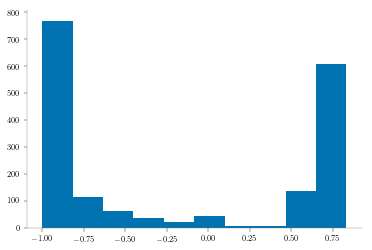

In [20]:
plt.hist(trial_corrs[1:, 1, 0])

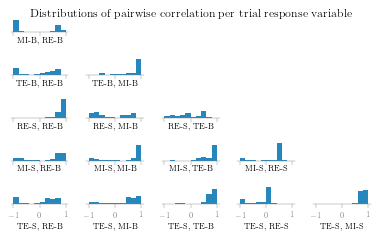

In [86]:
fig, axes = plt.subplots(5,5, figsize=set_size(textwidth, subplot=[5,5]), sharex=True, sharey=True)

bins = np.arange(-1, 1.2, 0.2)
bins[5] = 0

for j in range(1, 6):
    for k in range(6-1):
        ax = axes[j-1, k]
        
        if j > k:
            corr_data = trial_corrs[1:, j, k]
            weights = np.ones_like(corr_data)/corr_data.size
            ax.hist(corr_data, bins=bins, weights=weights, alpha=0.85)
            ax.set_xlabel(f'{response_variable_short_labels[j]}, {response_variable_short_labels[k]}', size=8)
            ax.get_yaxis().set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.tick_params(axis='x', colors='grey')
            
        else:
            ax.axis('off')

fig.suptitle('Distributions of pairwise correlation per trial response variable')
fig.tight_layout()

In [87]:
fig.savefig(f'all_rv_correlation_hist.pdf', format='pdf', bbox_inches='tight')    

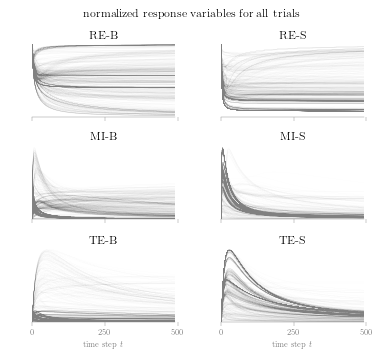

In [76]:
# fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=set_size(textwidth), gridspec_kw={'width_ratios': [7, 1], 'wspace': 0.05}, sharey=True)
MAX_T = 490 ###

def make_time_series_line_plot(ax1, rv):
    for i in range(MIN_TRIAL, MAX_TRIAL+1):
        ax1.plot(data[i, MIN_T:MAX_T+1, rv, INDEX_MEANS], marker='', color='grey', linewidth=0.05, alpha=0.1)
#         break ###

    ax1.set_title(f'{response_variable_short_labels[rv]}')
#     ax1.set_xlabel('time step $t$', color='grey')

    ax1.set_xticks([0, 250, 500])
    ax1.set_ylim((0, data[MIN_TRIAL:MAX_TRIAL+1, MIN_T:MAX_T+1, rv, INDEX_MEANS].max()))

    # more decoration
    ax1.spines['bottom'].set_color('grey')
    ax1.spines['left'].set_visible(False)

    ax1.tick_params(axis='x', colors='grey')
    ax1.tick_params(axis='y', colors='None')

    ax1.spines['bottom'].set_bounds(MIN_T, MAX_T)

    
fig, axes = plt.subplots(3,2, figsize=set_size(textwidth, subplot=[3,2]), sharex=True)
for rv, ax in enumerate(axes.T.reshape(-1)):
    make_time_series_line_plot(ax, rv)

for col in range(2):
    axes[-1, col].set_xlabel('time step $t$', color='grey')
    
fig.suptitle('normalized response variables for all trials')
fig.tight_layout()
fig.subplots_adjust(top=0.875)


In [77]:
fig.savefig(f'all_time_series_line_plots_tall.pdf', format='pdf', bbox_inches='tight')    

In [141]:
# compositing DTW clusters heatmap together

clusters_df2 = design_df.copy()

mode = 'dtw'

for rv in range(0, 6):
    # load R's cluster indices from file
    with open(f'./{mode}_best_clusters_rv_{rv}.csv', 'r') as f:
        cluster_ids = [int(i) for i in f.readline()[:-1].split(',')]

    clusters_df2[f'cluster_{mode}_{rv}'] = cluster_ids
    
    

In [142]:
import string

def get_census_vals(mode, clusters_df):
    output = []
    cluster_nums_dict = dict()
    
    rows = []  # row labels
    for (factor, levels) in factors.items():
        for i, level in enumerate(levels):
            rows.append(f"{string.ascii_lowercase[i]}")  # rows = columns now
        rows.append('')  # blank label for between factors
        
    for rv in range(0, 6):
        census_vals = []  # count of trials with both a given factor-level and cluster number divided by cluster size
        
        cluster_col = f'cluster_{mode}_{rv}'
        cluster_nums = sorted(clusters_df[cluster_col].unique())
        cluster_nums_dict[rv] = cluster_nums
    
        for (factor, levels) in factors.items():
            for i, level in enumerate(levels):
                # "census" of each cluster..."what does each cluster look like?"...take frequency per factor per cluster
                census_vals.append([len(clusters_df[(clusters_df[cluster_col] == cluster_num) & (clusters_df[factor] == level)]) 
                                 / len(clusters_df[(clusters_df[cluster_col] == cluster_num)]) for cluster_num in cluster_nums])

            census_vals.append([np.nan]*len(cluster_nums))  # blank data to render as gap

        census_vals = np.array(census_vals[:-1]).T  # remove last element since it's blank
        output.append(census_vals)
            
    
    return output, np.array(rows[:-1]), cluster_nums_dict
                    

census_output, row_labels, cluster_nums_dict = get_census_vals(mode, clusters_df2)       
nans = [[np.nan]*census_output[0].shape[1] for _ in census_output]



In [143]:
nans = [np.full((1, census_output[0].shape[1]), np.nan) for _ in census_output]

In [144]:
census_data = np.concatenate([x for t in zip(census_output, nans) for x in t], axis=0)[:-1]
# x for t in zip(...) for x in t   is how you flatten a list of tuples. who knew.

In [145]:
gap_indices = np.argwhere(row_labels == '').reshape(-1)
gap_indices = np.insert(gap_indices, [0, gap_indices.size], [-1, row_labels.size])
factor_name_xs = 0.5 + (gap_indices[1:] + gap_indices[:-1]) / 2

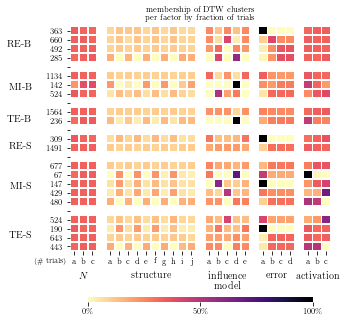

In [153]:
fig, ax = plt.subplots(1, 1, figsize=set_size(textwidth, fraction=1.5))

pcm = ax.pcolormesh(census_data, edgecolors='w', linewidth=0.5, vmin=0, vmax=1, cmap='magma_r')
ax.set_aspect('equal')
ax.invert_yaxis()

cbar = ax.figure.colorbar(pcm, ax=ax, shrink=0.40, aspect=50, pad=0.145,
                          orientation='horizontal', ticks=[0, 0.5, 1], drawedges=False)
cbar.ax.set_xticklabels(['0\%', '50\%', '100\%'])
cbar.outline.set_color('None')

ax.set_title(f"membership of DTW clusters\nper factor by fraction of trials")

# We want to show all ticks...
ax.set_yticks(np.arange(25)+0.5)  # ehhh, i just counted 'em
ax.set_xticks(np.arange(len(row_labels))+0.5)
# ... and label them with the respective list entries
ax.set_yticklabels([])
ax.set_xticklabels(row_labels)

# hide the tick marks for the gaps
xticks = ax.xaxis.get_major_ticks()
for i in gap_indices[1:-1]:  # don't include the ones I added
    xticks[i].set_visible(False)
    
# add trial counts for cluster size
ax.annotate('(\# trials)', (-4, 26.25), fontsize=7, annotation_clip=False)
ylabs = []
for rv in range(6):
    ylabs.extend([f'{j}' for i, j in clusters_df2.groupby(by=f'cluster_{mode}_{rv}').agg('size').iteritems()])
    ylabs.append(None)
ax.set_yticklabels(ylabs[:-1])


for edge, spine in ax.spines.items():
    spine.set_visible(False)

y = ax.get_ybound()[0]
for factor, x in zip(factors.keys(), factor_name_xs):
    ax.annotate(label_map[factor].replace(' ', '\n'), (x, y), 
                 fontsize=10,
                 textcoords="offset points", # how to position the text
                 xytext=(0,-245), # distance from text to points (x,y)  # -65 for 4 clusters, -42 for 2, -53 for 3
                 ha='center', va='top', annotation_clip=False)

    
rv_ys = [2, 6.75, 10.25, 13.25, 17.75, 23.25]
x = ax.get_xbound()[0]
for rv in range(6):
    rv_label = response_variable_short_labels[rv]
    ax.annotate(rv_label, (x-4.25, rv_ys[rv]), fontsize=10, textcoords="offset points", xytext=(0, 0),
                ha='right', va='center', annotation_clip=False)
    

fig.tight_layout()

In [154]:
fig.savefig(f'membership_of_cluster_{mode}_all_rvs.pdf', format='pdf', bbox_inches='tight')    